In [17]:
import pandas as pd
import pickle as pkl
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, KFold, cross_val_predict
from sklearn.metrics import r2_score, explained_variance_score, normalized_mutual_info_score, \
    mutual_info_score, mean_absolute_error, make_scorer
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from skll.metrics import spearman, pearson 


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [2]:
from dairyml import plot_coefficients, BoundedRidge, BoundedRidgePlusLogReg

### Load the data

In [3]:
with open("../pkl/data/data_outliers_removed", "rb" ) as f:
    [X, Y] = pkl.load(f)

### Modeling with Ridge

In [4]:
splitter= KFold(n_splits=10,shuffle=True,random_state=7)

In [5]:
scoring = {'r2':make_scorer(r2_score), 
           'SRC':make_scorer(spearman), 
           'PCC':make_scorer(pearson), 
           'MI':make_scorer(mutual_info_score), 
           'MAE':make_scorer(mean_absolute_error)}

In [6]:
try:
    overall_results = pd.read_csv('../reports/model_results.csv',index_col=0)
except FileNotFoundError:
    overall_results = pd.DataFrame(columns = scoring.keys())

#### Ridge

In [7]:
param_grid = {'alpha': np.logspace(-3, 3, 50)}

refit = 'r2'

search = GridSearchCV(estimator=Ridge(),param_grid=param_grid,scoring=scoring,refit=refit,cv=splitter)
fitted = search.fit(X,Y)

In [8]:
model = fitted.best_estimator_
with open("../models/ridge.model", "wb" ) as f:
    pkl.dump(model,f)

In [9]:
search.best_estimator_.alpha

59.636233165946365

In [10]:
search.cv_results_['mean_test_r2'][np.argmax(search.cv_results_['mean_test_'+refit])]

0.4172369080972337

In [11]:
for score_name in scoring.keys():
    overall_results.loc['Ridge',score_name] = np.round(search.cv_results_['mean_test_'+score_name][np.argmax(search.cv_results_['mean_test_'+refit])],2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0.00,-0.00,-0.00,1.94
Dummy Median All,-0.32,0.00,-0.00,-0.00,1.68
Dummy Median Nonzero,-0.08,0.00,-0.00,-0.00,1.77
"Perfect Clasif., Mean Regr.",0.13,0.73,0.41,0.53,1.53
Lasso,0.45,0.61,0.70,3.07,1.23
Bounded Lasso,0.55,0.64,0.75,2.87,1.08
Bounded Lasso + LogReg,0.64,0.80,0.82,2.66,0.86
FFNN (Regressor Only),0.77,0.78,0.88,3.07,0.66
XGB Regressor,0.80,0.85,0.90,3.06,0.47
XGB Combined,0.83,0.90,0.92,3.05,0.41


### Bounded Ridge

In [12]:
param_grid = {'alpha': np.logspace(-3, 3, 100)}

refit = 'r2'

search = GridSearchCV(estimator=BoundedRidge(),param_grid=param_grid,scoring=scoring,refit=refit,cv=splitter)
fitted = search.fit(X,Y)

In [13]:
model = fitted.best_estimator_
with open("../models/ridge_bounded.model", "wb" ) as f:
    pkl.dump(model,f)

In [14]:
search.best_estimator_.alpha

15.199110829529332

In [15]:
for score_name in scoring.keys():
    overall_results.loc['Bounded Ridge',score_name] = np.round(search.cv_results_['mean_test_'+score_name][np.argmax(search.cv_results_['mean_test_'+refit])],2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0.00,-0.00,-0.00,1.94
Dummy Median All,-0.32,0.00,-0.00,-0.00,1.68
Dummy Median Nonzero,-0.08,0.00,-0.00,-0.00,1.77
"Perfect Clasif., Mean Regr.",0.13,0.73,0.41,0.53,1.53
Lasso,0.45,0.61,0.70,3.07,1.23
Bounded Lasso,0.55,0.64,0.75,2.87,1.08
Bounded Lasso + LogReg,0.64,0.80,0.82,2.66,0.86
FFNN (Regressor Only),0.77,0.78,0.88,3.07,0.66
XGB Regressor,0.80,0.85,0.90,3.06,0.47
XGB Combined,0.83,0.90,0.92,3.05,0.41


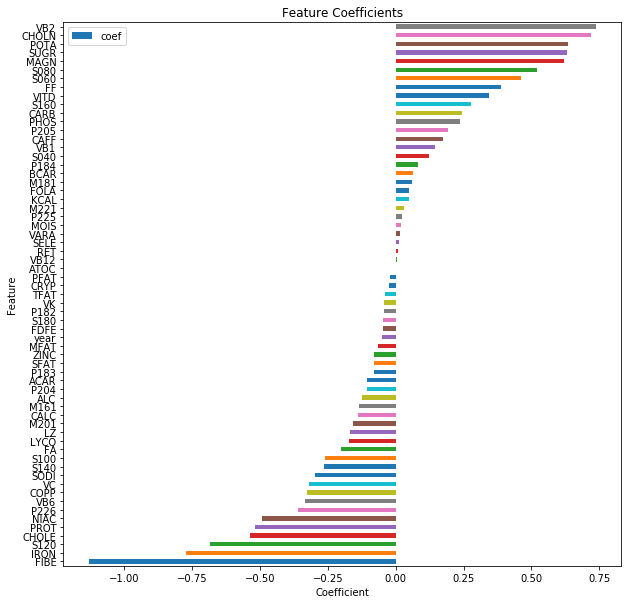

In [18]:
plot_coefficients(search.best_estimator_,X)

In [20]:
coefficients = pd.DataFrame()
coefficients['Feature'] = X.columns
coefficients['coef'] = abs(model.get_coef())
coefficients.to_csv('ridge_coef.csv')

### Bounded Ridge + LogReg

In [32]:
param_grid = {'alpha': np.logspace(-4, 3, 10), 'C': np.logspace(4, 6, 10)}
refit='r2'
search = GridSearchCV(estimator=BoundedRidgePlusLogReg(),param_grid=param_grid,scoring=scoring,refit=refit,cv=splitter)
fitted = search.fit(X,Y)

In [33]:
y_pred = cross_val_predict(search.best_estimator_,X,Y,cv=splitter)

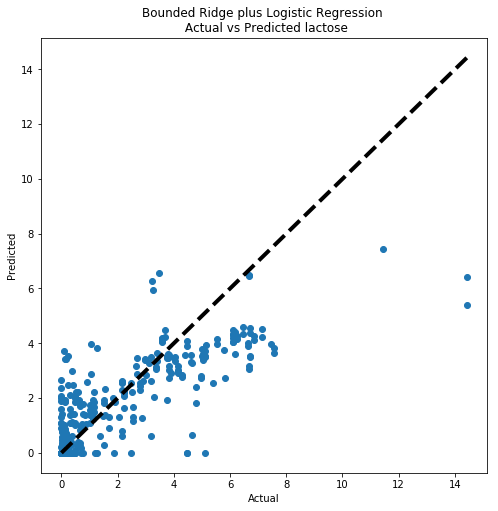

In [34]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(Y, y_pred)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Bounded Ridge plus Logistic Regression \n Actual vs Predicted lactose')
plt.show()

In [35]:
search.best_estimator_.get_params()

{'C': 215443.46900318822, 'alpha': 27.825594022071257}

In [36]:
for score_name in scoring.keys():
    overall_results.loc['Bounded Ridge + LogReg',score_name] = np.round(search.cv_results_['mean_test_'+score_name][np.argmax(search.cv_results_['mean_test_'+refit])],2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0.00,-0.00,-0.00,1.94
Dummy Median All,-0.32,0.00,-0.00,-0.00,1.68
Dummy Median Nonzero,-0.08,0.00,-0.00,-0.00,1.77
"Perfect Clasif., Mean Regr.",0.13,0.73,0.41,0.53,1.53
Lasso,0.45,0.61,0.70,3.07,1.23
Bounded Lasso,0.55,0.64,0.75,2.87,1.08
Bounded Lasso + LogReg,0.64,0.80,0.82,2.66,0.86
FFNN (Regressor Only),0.77,0.78,0.88,3.07,0.66
XGB Regressor,0.80,0.85,0.90,3.06,0.47
XGB Combined,0.83,0.90,0.92,3.05,0.41


In [37]:
overall_results.to_csv('../reports/model_results.csv')

In [38]:
model = fitted.best_estimator_
with open("../models/ridge_combined.model", "wb" ) as f:
    pkl.dump(model,f)